In [1]:
from scipy.io import loadmat
from scipy import stats
import numpy as np


from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

#import pandas as pd

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Implement Decision Tree method

In [2]:
#Function for entropy
def entropy(elem):
    unique, number = np.unique(elem, return_counts=True)
    pi = number/elem.shape[0] 
    entropy = 0
    for n in pi:
        r = -n*np.log2(n)
        entropy += r
    return entropy


In [3]:
# function for information gain
def information_gain2(target, feature, threshold):
    tt_entropy = entropy(target)
    
    groups = feature < threshold
    values, counts = np.unique(groups, return_counts=True)
    pi = counts/groups.shape[0]
    total = 0
    for elem, pi_val in zip(values,pi):
        mask = (groups == elem)
        weight = entropy(target[mask])
        total += pi_val*weight
    return (tt_entropy - total)

In [4]:
# calculate the split for a given feature, that maximazes the information gain.
# returns the best gain value, and the best  threshold for the given feature
def calculate_best_split_for_feature(target, feature):
    # get all the unique values
    values = np.unique(feature, return_counts=False)
    
    best_gain = -1
    split_threshold = -999
    count = 0
    for element in values:
        if(count==0):
            # if first elem in the array jump to the next, becouse this will not generate an split, all the elements will be in the same branch
            count+=1
            continue
        # calculate the information gain with that split
        gain = information_gain2(target, feature, element)
        
        # check if the gain is better than the previous best gain
        if (best_gain<gain):
            # save the best gain, and the best split
            best_gain = gain
            split_threshold = element
        
    return (best_gain, split_threshold)

In [5]:
# find the best feature to split and the best value to split it by
def split_dataset(features, labels):
    num_instances, num_features = features.shape
    num_instances_labels, num_cols = labels.shape
    if(num_instances!=num_instances_labels):
        raise Exception('Features and Labels Not same Size: '+ str(features.shape[0]) + " != " + str(labels.shape[0]))
    if(num_cols!=1):
        raise Exception('Labels size greater than 1: ' + str(labels.shape[1]))
    
    #gains_list = []# to save all the gains
    #thresholds_list = [] # to save all the thresholds
    
    best_gain = -1
    split_threshold = -999
    best_feature = -1
    
    labels_row = labels[:,0]# Convert the labels column to a row
    #iterate all features, to find the best one
    for i in range(num_features):
        #print(i)
        feature_row = features[:,i] # extract one column (feature) for the hole dataset, and convert it to row
        #print(feature_row)
        # Calculate the best split for the features, get the information gain and the threshold split
        gain, threshold = calculate_best_split_for_feature(labels_row, feature_row)
        
        #print(gain, threshold)
        
        #gains_list.append(gain) # save
        #thresholds_list.append(threshold) # save
        
        # check if the gain is better than the previous best gain
        if (best_gain<gain):
            # save the best gain, and the best split, and the best feature
            best_gain = gain
            split_threshold = threshold
            best_feature = i

    return(best_feature, best_gain, split_threshold)

In [6]:
class tree_node:
    attribute_split = None
    threshold = None
    information_gain = None
    right_child = None
    left_child = None
    depth = None
    mode_value = None
    
    def __init__(self, attribute_split, threshold, information_gain, right_child, left_child, depth, mode_value):
        self.attribute_split = attribute_split
        self.threshold = threshold
        self.information_gain = information_gain
        self.right_child = right_child
        self.left_child = left_child
        self.depth = depth
        self.mode_value = mode_value
    
    def setRight_child(self, child):
        self.right_child = child
    def setLeft_child(self, child):
        self.left_child = child
    
    def getRight_child(self):
        return self.right_child
    def geLeft_child(self):
        return self.left_child
    
    # get the depth of the tree
    def calculate_tree_depth(self):
        if (self.right_child is None):
            right_child_depth = 0
        else:
            right_child_depth = self.right_child.calculate_tree_depth()
        
        if (self.left_child is None):
            left_child_depth = 0
        else:
            left_child_depth = self.left_child.calculate_tree_depth()
        
        return( max( right_child_depth, left_child_depth) + 1 )
    
    def __str__(self):
        return f"Depth of the tree: {self.calculate_tree_depth()}\nCurrent Node Split atribute {self.attribute_split} by threshold {self.threshold}. \nInformation gain of the split {self.information_gain} \nDepth of the Node: {self.depth}. Mode label: {self.mode_value} \nUse: getRight_child() and getLeft_child() to see childs of the tree"
        
        
        

In [7]:
# Main function to use to train the decision tree. 
# works recursively. Initial Call let depth as default, or 0
def create_tree(features, labels, max_depth=None, min_information_gain=None, depth = 0):
    print(f"Depth {depth} of Max depth {max_depth}")
    
    if((max_depth is not None) and (depth == max_depth)):
        # the max depth has been reach, so we come back
        print("Max depth reached, Don't explore this branch more")
        node = tree_node(attribute_split = -1, 
                         threshold = -999, 
                         information_gain = -1, 
                         right_child = None, 
                         left_child = None, 
                         depth = depth, 
                         mode_value = stats.mode(np.moveaxis(labels, 0, -1)[0]).mode[0])
        return(node)
    
    # Calculate the best atribute to split by, the best threshold, and the information Gain
    feature_split, gain_split, threshold_split = split_dataset(features, labels)
    
    if(gain_split == -1):
        # this means that no split was generated (Only 1 elem remains)
        print("Only 1 Elem Remains") 
        #create the tree node
        node = tree_node(attribute_split = -1, 
                         threshold = -999, 
                         information_gain = -1, 
                         right_child = None, 
                         left_child = None, 
                         depth = depth, 
                         mode_value = stats.mode(np.moveaxis(labels, 0, -1)[0]).mode[0])
        return(node)
    
    if ( (min_information_gain is not None) and (gain_split < min_information_gain)):
        # the best gain is less than the minimun information gain set,
        print("Not enough information gain")
        #create the tree node
        node = tree_node(attribute_split = -1, 
                         threshold = -999, 
                         information_gain = -1, 
                         right_child = None, 
                         left_child = None, 
                         depth = depth, 
                         mode_value = stats.mode(np.moveaxis(labels, 0, -1)[0]).mode[0])
        
        return(node)
    
    
    
    
    
    mode_label = stats.mode(np.moveaxis(labels, 0, -1)[0]).mode[0]# get the most frequent label
    
    
    #create the tree node
    node = tree_node(attribute_split = feature_split, 
                     threshold = threshold_split, 
                     information_gain = gain_split, 
                     right_child = None, 
                     left_child = None, 
                     depth = depth, 
                     mode_value = mode_label)
    
    # Split dataset base on condition
    mask_left = (features[:,feature_split] < threshold_split)
    mask_right = np.invert(mask_left)
    
    
    # Call function for left and rigth splits
    print(f"Left child search...(0/2)")
    left_subtree = create_tree(features[mask_left], 
                               labels[mask_left], 
                               max_depth=max_depth, 
                               min_information_gain=min_information_gain, 
                               depth = depth+1)
    print(f"Right child search...(1/2)")
    right_subtree = create_tree(features[mask_right], 
                                labels[mask_right], 
                                max_depth=max_depth, 
                                min_information_gain=min_information_gain, 
                                depth = depth+1)
    print(f"END child search...(2/2)")
    # Set the subtrees
    node.setLeft_child(left_subtree)
    node.setRight_child(right_subtree)
    
    if(left_subtree is None and right_subtree is not None):
        print("-----------------------------------------ONLY ONE CHILD-----------------------------------------")
    if(right_subtree is None and left_subtree is not None):
        print("-----------------------------------------ONLY ONE CHILD-----------------------------------------")
    
    return(node)

In [8]:
# given a set of features, find the best label according to the tree
def find_prediction_on_tree(features, tree):
    attribute = tree.attribute_split
    threshold = tree.threshold
    
    if(attribute == -1):
        # the node doesn't have childs
        return tree.mode_value
    
    if(features[attribute] < threshold):
        #left child
        sub_tree = tree.geLeft_child()
    else:
        #rigth child
        sub_tree = tree.getRight_child()
        
    if(sub_tree is None):
        # if there is no subtree, return the mode of the current node
        return tree.mode_value
    else:
        #if there is a subtree, reiterate
        return find_prediction_on_tree(features, sub_tree)
    

In [9]:
# make predictions for all test features, using the tree
def make_predictions(test_features, tree):
    num_instances, num_features = test_features.shape
    
    predictions =[]
    # iterate all the instances
    for instance in range(num_instances):
        elem = test_features[instance]
        
        label = find_prediction_on_tree(elem, tree)
        predictions.append(label)
    return(predictions)

# 2. Load train and test mat files, perform Decision Tree and report acuracy on the test dataset

In [10]:
# Open the model
train_dataset = loadmat('train.mat')
#print(annots)

In [11]:
train_dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Oct 12 22:10:47 2022',
 '__version__': '1.0',
 '__globals__': [],
 'features': array([[-1.9087052e-01, -8.1624687e-01, -1.6324869e-01, ...,
         -1.7326276e-01, -3.3678705e-01,  1.4531960e+00],
        [-1.0689135e+00, -6.6361743e-01, -5.4769421e-01, ...,
          2.3691764e-01, -7.9150289e-01,  1.6607733e+00],
        [ 2.1004608e-01, -5.4553837e-01, -2.3526147e-01, ...,
          2.2105977e-01,  3.2690910e-01, -5.7891858e-01],
        ...,
        [ 3.0305445e-02,  1.2849410e-01, -3.2814008e-01, ...,
         -3.9511231e-01, -2.8412789e-04, -1.9695227e-01],
        [ 4.0498897e-02,  3.7712151e-01, -3.0760404e-01, ...,
         -4.9570936e-01, -7.3815003e-02, -1.6422004e-02],
        [ 1.5795332e-01,  5.9384692e-01, -1.9313660e-01, ...,
         -1.9358669e-01, -4.4733964e-02, -3.8367152e-01]], dtype=float32),
 'labels': array([[ 1],
        [ 1],
        [ 1],
        ...,
        [10],
        [10],
       

In [12]:
train_features = train_dataset['features']
train_labels = train_dataset['labels']
print(train_features.shape)
print(train_labels.shape)

(1123, 1000)
(1123, 1)


In [13]:

# Open the model
test_dataset = loadmat('test.mat')
#print(annots)

In [14]:
test_dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Oct 16 11:43:39 2022',
 '__version__': '1.0',
 '__globals__': [],
 'features': array([[-0.1810047 , -0.3263064 ,  0.09900231, ...,  0.0896374 ,
          0.30170187, -0.315777  ],
        [-0.08604874, -0.24425426,  0.03491393, ...,  0.15105137,
          0.14930305, -0.50344443],
        [-0.02536274, -0.22994491,  0.0929625 , ...,  0.21274611,
          0.08147568, -0.5320467 ],
        ...,
        [-0.19452816,  0.09794576, -0.37737143, ..., -0.465474  ,
          0.04289951, -0.2871586 ],
        [-0.04896154,  0.2931249 , -0.28049102, ..., -0.2639083 ,
         -0.09265084, -0.3752439 ],
        [-0.09236805,  0.1781122 , -0.40881082, ..., -0.36157244,
          0.17647949, -0.36177444]], dtype=float32),
 'labels': array([[ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
  

In [15]:
test_features = test_dataset['features']
test_labels = test_dataset['labels']
print(test_features.shape)
print(test_labels.shape)

(958, 1000)
(958, 1)


### Train Model

In [16]:
TREE_DEPTH = 7
MIN_INFO_GAIN = 0.1

trained_tree = create_tree(train_features, 
                           train_labels, 
                           max_depth=TREE_DEPTH, 
                           min_information_gain=MIN_INFO_GAIN, 
                           depth = 0)

Depth 0 of Max depth 7
Left child search...(0/2)
Depth 1 of Max depth 7
Left child search...(0/2)
Depth 2 of Max depth 7
Left child search...(0/2)
Depth 3 of Max depth 7
Left child search...(0/2)
Depth 4 of Max depth 7
Left child search...(0/2)
Depth 5 of Max depth 7
Left child search...(0/2)
Depth 6 of Max depth 7
Not enough information gain
Right child search...(1/2)
Depth 6 of Max depth 7
Left child search...(0/2)
Depth 7 of Max depth 7
Max depth reached, Don't explore this branch more
Right child search...(1/2)
Depth 7 of Max depth 7
Max depth reached, Don't explore this branch more
END child search...(2/2)
END child search...(2/2)
Right child search...(1/2)
Depth 5 of Max depth 7
Not enough information gain
END child search...(2/2)
Right child search...(1/2)
Depth 4 of Max depth 7
Left child search...(0/2)
Depth 5 of Max depth 7
Not enough information gain
Right child search...(1/2)
Depth 5 of Max depth 7
Not enough information gain
END child search...(2/2)
END child search...(2/2

In [17]:
print(trained_tree)

Depth of the tree: 8
Current Node Split atribute 508 by threshold 1.1029484272003174. 
Information gain of the split 0.7564324430997167 
Depth of the Node: 0. Mode label: 1 
Use: getRight_child() and getLeft_child() to see childs of the tree


### Make Prediction

In [18]:
predictions = make_predictions(test_features, trained_tree)
np.array(predictions)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  2,  2,  2,  4,  2,  2,  2,
       10,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  1,  2,  2,  3,  3,  3,  3,  5,  5,  5,  3,  3,  3,  3,  3,  4,
        5,  3,  3,  3,  3,  3,  3,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  5,  3,  3,  3,  1,  3,  3,  3,  3,  5,  3,
        3,  3,  3,  4,  3

In [19]:
np.moveaxis(test_labels, 0, -1)[0]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

In [20]:
# Calculate Accuracy
acc = accuracy_score(np.moveaxis(test_labels, 0, -1)[0], predictions)

print("Accuracy: ", acc*100, "%")

Accuracy:  91.23173277661796 %


# 3. Reduce the dimensionality of features using PCA to low dimensions (e.g., 10, 3 ) and report the accuracy of the test datasets

In [21]:
pca = PCA(n_components=10)
pca.fit(train_features)

PCA(n_components=10)

In [22]:
pca_train_features = pca.transform(train_features)
pca_test_features = pca.transform(test_features)

In [23]:
trained_tree_pca = create_tree(pca_train_features, 
                               train_labels, 
                               max_depth=TREE_DEPTH, 
                               min_information_gain=MIN_INFO_GAIN, 
                               depth = 0)

Depth 0 of Max depth 7
Left child search...(0/2)
Depth 1 of Max depth 7
Left child search...(0/2)
Depth 2 of Max depth 7
Left child search...(0/2)
Depth 3 of Max depth 7
Left child search...(0/2)
Depth 4 of Max depth 7
Left child search...(0/2)
Depth 5 of Max depth 7
Left child search...(0/2)
Depth 6 of Max depth 7
Not enough information gain
Right child search...(1/2)
Depth 6 of Max depth 7
Left child search...(0/2)
Depth 7 of Max depth 7
Max depth reached, Don't explore this branch more
Right child search...(1/2)
Depth 7 of Max depth 7
Max depth reached, Don't explore this branch more
END child search...(2/2)
END child search...(2/2)
Right child search...(1/2)
Depth 5 of Max depth 7
Left child search...(0/2)
Depth 6 of Max depth 7
Left child search...(0/2)
Depth 7 of Max depth 7
Max depth reached, Don't explore this branch more
Right child search...(1/2)
Depth 7 of Max depth 7
Max depth reached, Don't explore this branch more
END child search...(2/2)
Right child search...(1/2)
Depth 

In [24]:
print(trained_tree_pca)

Depth of the tree: 8
Current Node Split atribute 0 by threshold 6.339794635772705. 
Information gain of the split 0.8131769853151845 
Depth of the Node: 0. Mode label: 1 
Use: getRight_child() and getLeft_child() to see childs of the tree


In [25]:
predictions_pca = make_predictions(pca_test_features, trained_tree_pca)
np.array(predictions_pca)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1,  5,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1,  1,  5,  1,
        1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  4,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

In [26]:
np.moveaxis(test_labels, 0, -1)[0]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

In [27]:
# Calculate Accuracy
acc_pca = accuracy_score(np.moveaxis(test_labels, 0, -1)[0], predictions_pca)

print("Accuracy: ", acc_pca*100, "%")

Accuracy:  93.52818371607515 %


# 4. Compare results with KNN model

Accuracy of KNN on 1000 features:
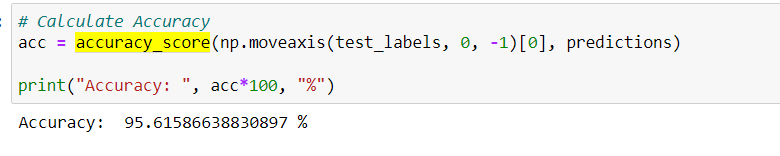

Accuracy of KNN on 10 features, using PCA
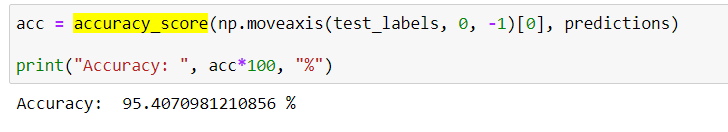

The accuracy of the decision tree using the 1000 features is 91.23% while the KNN for 1000 features was 95.61%. And if we use PCA reducing the dimensionality to 10 features, the Decision tree accuracy is 93.52% while the KNN was 95.40%. In both cases the KNN method achieved a higher accuracy than the Decision tree. In the case of using only 10 features the difference between both methods got reduced.